## TESTE 1: Diretamente com métrica "Acurácia" - que não é das melhores, pois tende a acertar mais do que balancear a distribuição de acertos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_path = '/content/drive/MyDrive/IA901/interim2.zip'

In [ ]:
!unzip "{zip_file_path}" -d "/content/drive/MyDrive/IA901/interim2"

Archive:  /content/drive/MyDrive/IA901/interim2.zip
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0015719.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0075914.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0076742.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0077472.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0077735.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0079038.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0082543.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0097997.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0109869.jpg  
  inflating: /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0149698.jpg  
replace /content/drive/MyDrive/IA901/interim2/benigno/ISIC_0154253.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/drive/MyDrive/IA901/interim2/benig

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Contagem do número de arquivos nas pastas 
folder_path1 = '/content/drive/MyDrive/IA901/interim2/benigno'
folder_path2 = '/content/drive/MyDrive/IA901/interim2/maligno'

In [ ]:
import os
file_count1 = sum(len(files) for _, _, files in os.walk(folder_path1))
file_count2 = sum(len(files) for _, _, files in os.walk(folder_path2))
print(file_count1,file_count2)

3243 582


In [ ]:
image_size = (250, 250)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/IA901/interim2",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3825 files belonging to 2 classes.
Using 3060 files for training.
Using 765 files for validation.


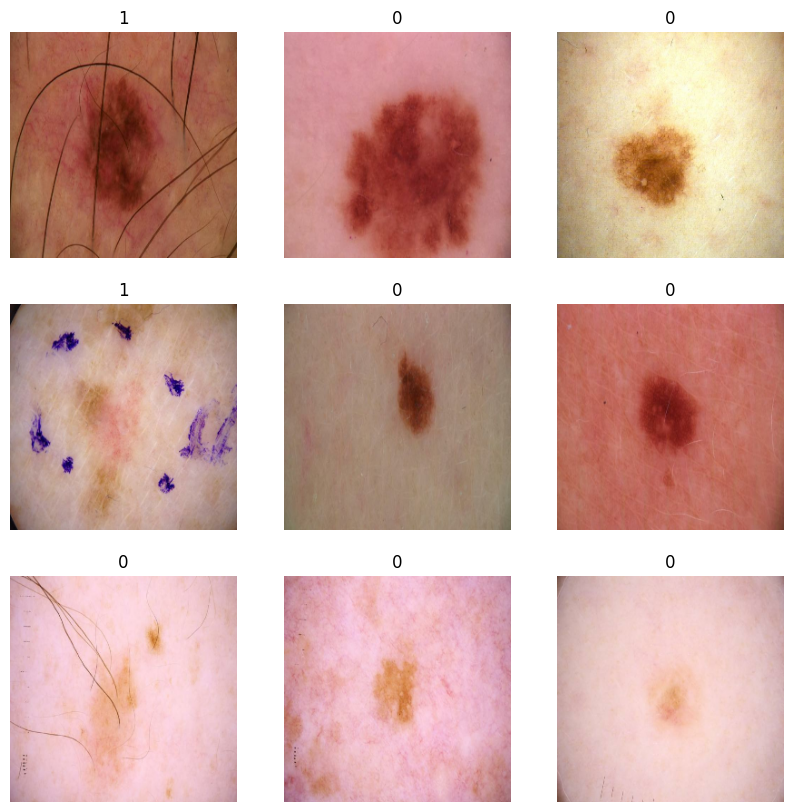

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.1),
        layers.RandomRotation(0.3),
    ]
)

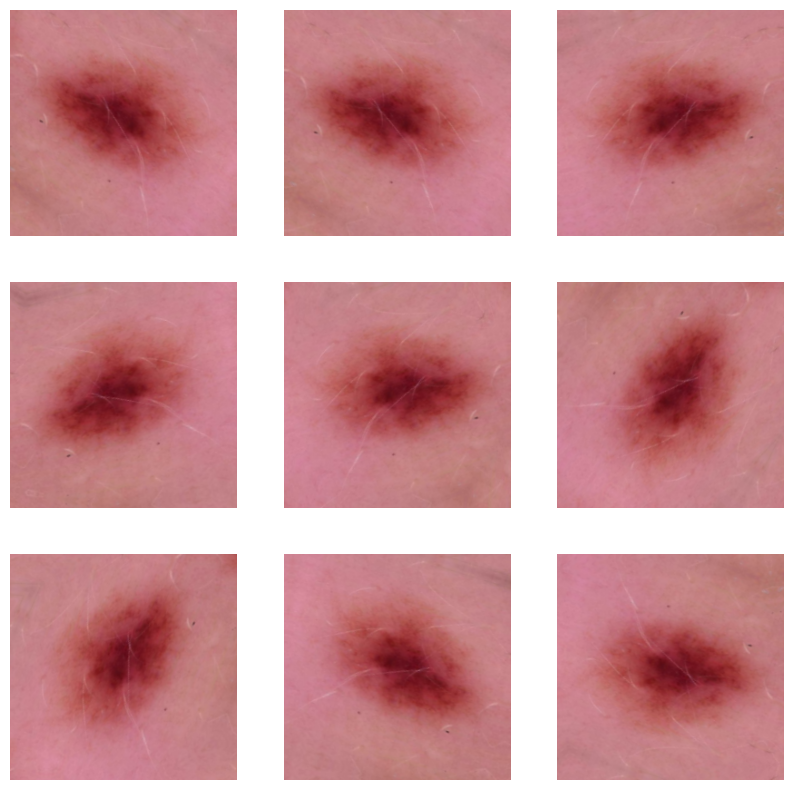

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model_history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25
192/192 [==============================] - 19s 58ms/step - loss: 0.4355 - accuracy: 0.8265 - val_loss: 0.5150 - val_accuracy: 0.8458
Epoch 2/25
192/192 [==============================] - 11s 55ms/step - loss: 0.3878 - accuracy: 0.8441 - val_loss: 0.3789 - val_accuracy: 0.8458
Epoch 3/25
192/192 [==============================] - 11s 55ms/step - loss: 0.3803 - accuracy: 0.8467 - val_loss: 0.4000 - val_accuracy: 0.8471
Epoch 4/25
192/192 [==============================] - 11s 56ms/step - loss: 0.3803 - accuracy: 0.8477 - val_loss: 0.8263 - val_accuracy: 0.5098
Epoch 5/25
192/192 [==============================] - 11s 55ms/step - loss: 0.3739 - accuracy: 0.8484 - val_loss: 0.5493 - val_accuracy: 0.7660
Epoch 6/25
192/192 [==============================] - 11s 55ms/step - loss: 0.3723 - accuracy: 0.8467 - val_loss: 0.5661 - val_accuracy: 0.8458
Epoch 7/25
192/192 [==============================] - 11s 55ms/step - loss: 0.3587 - accuracy: 0.8477 - val_loss: 0.4222 - val_accuracy:

In [ ]:
model_history.history

{'loss': [0.4354894757270813,
  0.3877549171447754,
  0.3803004026412964,
  0.3803049623966217,
  0.3738928437232971,
  0.3722720742225647,
  0.3586854636669159,
  0.3635760545730591,
  0.34772568941116333,
  0.34998568892478943,
  0.351651668548584,
  0.34253764152526855,
  0.3433610796928406,
  0.3390790522098541,
  0.3395465016365051,
  0.33436691761016846,
  0.3260762095451355,
  0.3298620581626892,
  0.3269912898540497,
  0.3288891017436981,
  0.3234904110431671,
  0.32185596227645874,
  0.3265175521373749,
  0.3154829144477844,
  0.32276904582977295],
 'accuracy': [0.8264706134796143,
  0.8441176414489746,
  0.8467320203781128,
  0.8477123975753784,
  0.8483660221099854,
  0.8467320203781128,
  0.8477123975753784,
  0.8496732115745544,
  0.8500000238418579,
  0.8522875905036926,
  0.851307213306427,
  0.8571895360946655,
  0.851307213306427,
  0.8558823466300964,
  0.8549019694328308,
  0.8552287817001343,
  0.855555534362793,
  0.8568627238273621,
  0.8526144027709961,
  0.85457

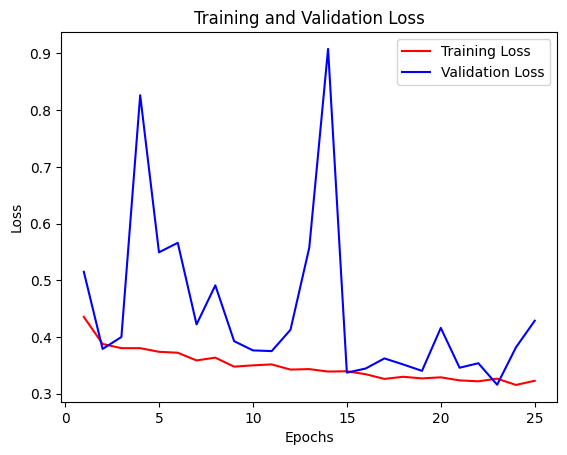

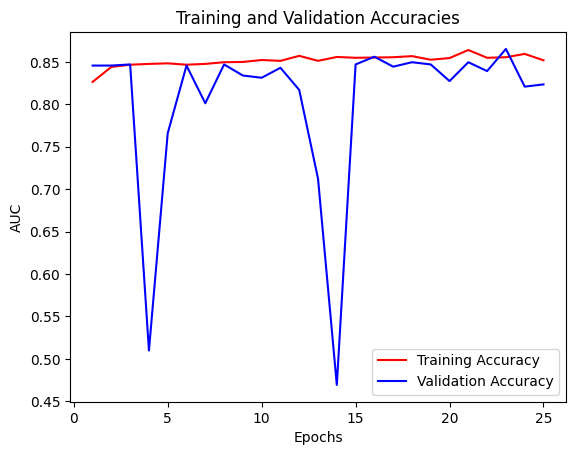

In [ ]:
import matplotlib.pyplot as plt


train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
train_auc = model_history.history['accuracy']
val_auc = model_history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, train_auc, 'r', label='Training Accuracy')
plt.plot(epochs, val_auc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras

image_size = (250, 250)  # Specify the target image size

# Load the trained model
#model = keras.models.load_model('your_model.h5')  # Replace 'your_model.h5' with your actual model file

# Iterate over the images in the dataset
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    # Iterate over each predicted label in the batch
    for i in range(len(predicted_labels)):
        image_path = val_ds.file_paths[i]  # Get the image path from the dataset
        class_names = val_ds.class_names  # Get the class names from the dataset
        predicted_class = class_names[predicted_labels[i]]
        
        # Print the prediction result
        print(f"{image_path}: Predicted class is {predicted_class}.")

1/1 [==============================] - 0s 280ms/step
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_7526857.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_7696762.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_5644405.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/maligno/ISIC_9998682.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_5509212.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_0799535.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_8887142.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_4344870.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_9860895.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA901/interim2/benigno/ISIC_4507700.jpg: Predicted class is benigno.
/content/drive/MyDrive/IA90

1/1 [==============================] - 0s 27ms/step


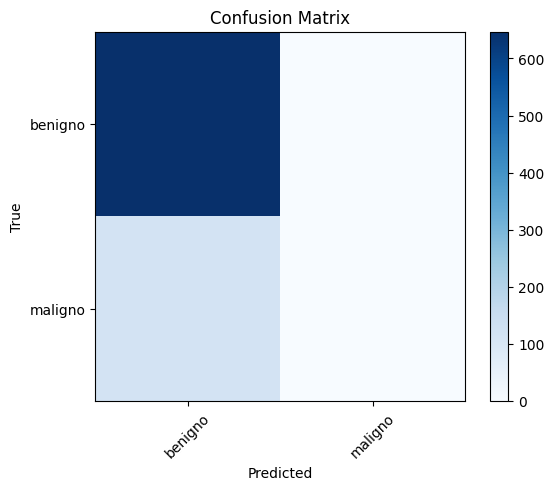

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras

image_size = (250, 250)  # Specify the target image size

# Load the trained model
#model = keras.models.load_model('your_model.h5')  # Replace 'your_model.h5' with your actual model file

# Initialize lists to accumulate true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the images in the dataset
for images, labels in val_ds:
    predictions = model.predict(images)
    batch_predicted_labels = tf.argmax(predictions, axis=1)
    
    true_labels.extend(labels)
    predicted_labels.extend(batch_predicted_labels)

# Convert the accumulated labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
class_names = val_ds.class_names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 26ms/step


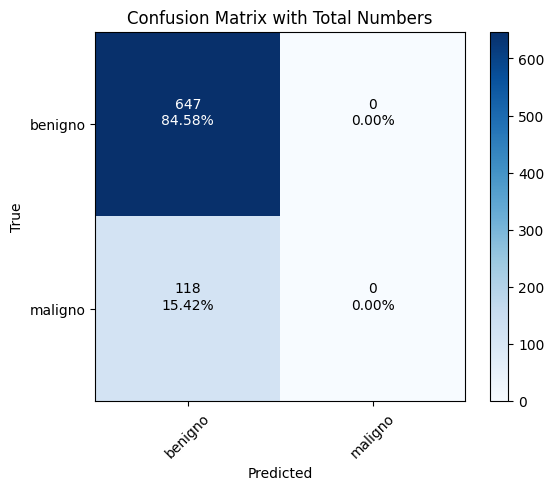

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow import keras

image_size = (250, 250)  # Specify the target image size

# Load the trained model
#model = keras.models.load_model('your_model.h5')  # Replace 'your_model.h5' with your actual model file

# Initialize lists to accumulate true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the images in the dataset
for images, labels in val_ds:
    predictions = model.predict(images)
    batch_predicted_labels = tf.argmax(predictions, axis=1)
    
    true_labels.extend(labels)
    predicted_labels.extend(batch_predicted_labels)

# Convert the accumulated labels to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix with total numbers
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()

class_names = val_ds.class_names
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

# Calculate the total numbers in each group
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

# Add the total numbers to the plot
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(cm.shape[0], cm.shape[1])

# Show the total numbers in each group
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, labels[i, j], horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Total Numbers')
plt.show()
